<a href="https://colab.research.google.com/github/NathanJGaul/100-days-of-python/blob/main/Thesis_UNet_with_segmentation_models_(Tensorflow_2)_patching_hyperparams.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Port Forwarding to Remote

```bash
ssh nathan@172.29.134.151
et nathan@172.29.134.151
```

```bash
ssh -L 8081:0.0.0.0:8081 nathan@172.29.134.151
et -t 8081:8081 nathan@172.29.134.151
```

# Running the docker container

```bash
docker run \
--gpus all \
-it --rm -p 8081:8081 \
-e CLIENT_ID='548743269247-mu92gf535k925on7p5e7shu2tku1v3mp' \
-e CLIENT_SECRET='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' \
-e VERIFICATION_CODE='4/1AX4XfWjtfS9_LyhMZcPaf8tDPFc4Ao88MgsbRBVYsW9E87iFv7lUb4yqGB0' \
-v /home/nathan/Documents/data:/opt/data \
--security-opt apparmor:unconfined \
--cap-add mknod \
--cap-add sys_admin \
--device=/dev/fuse \
docker-colab-local-gdrive:latest
```

# Requirements

In [ ]:
import os
if 'COLAB_GPU' in os.environ:
  IN_COLAB = True
  print('Running in Colab')
else:
  IN_COLAB = False
  print('Not running in Colab')


Not running in Colab


In [ ]:
# Install required libs

### please update Albumentations to version>=0.3.0 for `Lambda` transform support
!pip3 install -U git+https://github.com/albu/albumentations --no-cache-dir
!pip3 install -U albumentations[imgaug]

if IN_COLAB:
  print('Installing supported version of Tensorflow and Keras')
  !pip3 install tensorflow==2.2
  !pip3 install keras==2.3.1

!pip3 install -U git+https://github.com/qubvel/segmentation_models
!pip3 install -U keras-tuner
!pip3 uninstall -y protobuf
!pip3 uninstall -y python3-protobuf
!pip3 install -U protobuf

%env SM_FRAMEWORK=tf.keras

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-1513xft4
  Running command git clone --filter=blob:none -q https://github.com/albu/albumentations /tmp/pip-req-build-1513xft4
  Resolved https://github.com/albu/albumentations to commit 37e714fd2e326f6f88778e425f98c2de8c8d5372
  Preparing metadata (setup.py) ... - done
  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-lqrzinll
  Running command git clone --filter=blob:none -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-lqrzinll
  Resolved https://github.com/qubvel/segmentation_models to commit 94f624b7029deb463c859efbd92fa26f512b52b8
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... - done
Found existing installation: protobuf 3.19.1
Uninstalling protobuf-3.19.1:
  Successfully uninstalled protobuf-3.19.1
  Using cached protobuf-3.19.1-cp36-cp36m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.1 MB)
env: SM_FRAMEWOR

In [ ]:
import os
import random
import gc
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

import cv2
import tensorflow as tf
import keras_applications as ka
import keras_tuner as kt
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# see https://stackoverflow.com/questions/64519523/oom-when-allocating-tensor-with-shape-how-to-get-more-gpu-memory
policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
tf.keras.mixed_precision.experimental.set_policy(policy)

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
# set seed for reproducibility
SEED = 42
random.seed(SEED)

# Loading Dataset

## Datasert Directories

In [ ]:
# dataset directories
SYNTHETIC_DATA_DIR = '/opt/data/cars_segmentation_synthetic'
SYNTHETIC_DATA_DIR_OLD = '/opt/data/old_cars_segmentation_synthetic'
REAL_DATA_DIR = '/opt/data/cars_segmentation_real'

In [ ]:
# images and annotation directories and ids
x_dir_synthetic = os.path.join(SYNTHETIC_DATA_DIR, 'images')
y_dir_synthetic = os.path.join(SYNTHETIC_DATA_DIR, 'annotations')

x_dir_synthetic_old = os.path.join(SYNTHETIC_DATA_DIR_OLD, 'images')
y_dir_synthetic_old = os.path.join(SYNTHETIC_DATA_DIR_OLD, 'annotations')

ids_synthetic = os.listdir(x_dir_synthetic)
ids_synthetic_old = os.listdir(x_dir_synthetic_old)

x_dir_real = os.path.join(REAL_DATA_DIR, 'images')
y_dir_real = os.path.join(REAL_DATA_DIR, 'annotations')

ids_real = os.listdir(x_dir_real)

In [ ]:
# shuffle and split ids into training, validation, and test datasets
# synthetic ---------------------------------------
TRAIN_RATIO_SYNTHETIC = 0.8
VALID_RATIO_SYNTHETIC = 0.2
assert (TRAIN_RATIO_SYNTHETIC + VALID_RATIO_SYNTHETIC) == 1

total_count_synthetic = len(ids_synthetic)
train_count_synthetic = int(total_count_synthetic * TRAIN_RATIO_SYNTHETIC)
valid_count_synthetic = int(total_count_synthetic * VALID_RATIO_SYNTHETIC)
assert (train_count_synthetic + valid_count_synthetic) == total_count_synthetic

# synthetic old ---------------------------------------
# TRAIN_RATIO_SYNTHETIC_OLD = 0.8
# VALID_RATIO_SYNTHETIC_OLD = 0.2
# assert (TRAIN_RATIO_SYNTHETIC_OLD + VALID_RATIO_SYNTHETIC_OLD) == 1

total_count_synthetic_old = len(ids_synthetic_old)
train_count_synthetic_old = 1500 #int(total_count_synthetic_old * TRAIN_RATIO_SYNTHETIC_OLD)
valid_count_synthetic_old = 376 #int(total_count_synthetic_old * VALID_RATIO_SYNTHETIC_OLD)
assert (train_count_synthetic_old + valid_count_synthetic_old) == total_count_synthetic_old

# real ---------------------------------------
# TRAIN_RATIO_REAL = 0.6
# VALID_RATIO_REAL = 0.2
# TEST_RATIO_REAL = 0.2
# assert (TRAIN_RATIO_REAL + VALID_RATIO_REAL + TEST_RATIO_REAL) == 1

total_count_real = len(ids_real)
train_count_real = 35 #int(total_count_real * TRAIN_RATIO_REAL)
valid_count_real = 12 #int(total_count_real * VALID_RATIO_REAL)
test_count_real =  12 #int(total_count_real * TEST_RATIO_REAL)
assert (train_count_real + valid_count_real + test_count_real) == total_count_real

# seed is set so shuffles are reproducible
random.shuffle(ids_synthetic)
random.shuffle(ids_synthetic_old)
random.shuffle(ids_real)

# synthetic
train_ids_synthetic = ids_synthetic[:train_count_synthetic]
valid_ids_synthetic = ids_synthetic[train_count_synthetic:]
assert len(train_ids_synthetic) == train_count_synthetic
assert len(valid_ids_synthetic) == valid_count_synthetic

# synthetic old
train_ids_synthetic_old = ids_synthetic_old[:train_count_synthetic_old]
valid_ids_synthetic_old = ids_synthetic_old[train_count_synthetic_old:]
assert len(train_ids_synthetic_old) == train_count_synthetic_old
assert len(valid_ids_synthetic_old) == valid_count_synthetic_old

# real
train_ids_real = ids_real[:train_count_real]
valid_ids_real = ids_real[train_count_real:(train_count_real + valid_count_real)]
test_ids_real = ids_real[(train_count_real + valid_count_real):]
assert len(train_ids_real) == train_count_real
assert len(valid_ids_real) == valid_count_real
assert len(test_ids_real) == test_count_real

print('Synthetic Dataset Stats:')
print(f'\t- Training Samples: {train_count_synthetic}')
print(f'\t- Validation Samples: {valid_count_synthetic}')

print('\nSynthetic Old Dataset Stats:')
print(f'\t- Training Samples: {train_count_synthetic_old}')
print(f'\t- Validation Samples: {valid_count_synthetic_old}')

print('\nRead Dataset Stats:')
print(f'\t- Training Samples: {train_count_real}')
print(f'\t- Validation Samples: {valid_count_real}')
print(f'\t- Test Samples: {test_count_real}')

Synthetic Dataset Stats:
	- Training Samples: 6400
	- Validation Samples: 1600

Synthetic Old Dataset Stats:
	- Training Samples: 1500
	- Validation Samples: 376

Read Dataset Stats:
	- Training Samples: 35
	- Validation Samples: 12
	- Test Samples: 12


## Dataloader and Utility Functions

In [ ]:
# classes for data loading and preprocessing
class Dataset:
  """Segmentation Dataset. Read images, apply augmentation and preprocessing transformations.

  Args:
    ids (array of str): ids to be loaded for this dataset
    images_dir (str): path to images folder
    masks_dir (str): path to segmentation masks folder
    augmentation (albumentations.Compose): data transformations pipeline
      (e.g. flip, scale, etc.)
    preprocessing (albumentations.Compose): data preprocessing
      (e.g. normalization, shape manipulation, etc.)
    
  """

  def __init__(
      self,
      ids,
      images_dir,
      masks_dir,
      augmentation=None,
      preprocessing=None,
  ):
    self.ids = ids
    self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
    self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]

    self.augmentation = augmentation
    self.preprocessing = preprocessing

  def __getitem__(self, i):
    
    # read data
    image = cv2.imread(self.images_fps[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(self.masks_fps[i], 0)
    mask = mask[..., tf.newaxis]
    mask[mask == 255] = 1

    # apply augmentations
    if self.augmentation:
      sample = self.augmentation(image=image, mask=mask)
      image, mask = sample['image'], sample['mask']

    # apply preprocessing
    if self.preprocessing:
      sample = self.preprocessing(image=image, mask=mask)
      image, mask = sample['image'], sample['mask']

    return image, mask

  def __len__(self):
    return len(self.ids)


class Dataloader(tf.keras.utils.Sequence):
  """Load data from dataset and form batches

  Args:
    dataset: instance of Dataset class for image loading and preprocessing
    batch_size: Integer number of images in batch.
    shuffle: Boolean, if `True` shuffle image indexes each epoch.

  """

  def __init__(self, dataset, batch_size=1, shuffle=False):
    self.dataset = dataset
    self.batch_size = batch_size
    self.shuffle = shuffle
    self.indexes = np.arange(len(dataset))

    self.on_epoch_end()

  def __getitem__(self, i):

    # collect batch data
    start = i * self.batch_size
    stop = (i + 1) * self.batch_size
    data = []
    for j in range(start, stop):
      data.append(self.dataset[j])
    
    # transpose list of lists
    batch = [np.stack(samples, axis=0) for samples in zip(*data)]

    return (batch[0], batch[1])

  def __len__(self):
    """Denotes the number of batches per epoch"""
    return len(self.indexes) // self.batch_size

  def on_epoch_end(self):
    """Callback functions to shuffle indexes each epoch"""
    if self.shuffle:
      self.indexes = np.random.permutation(self.indexes)

In [ ]:
def parse_image(images_dir: str, masks_dir: str):
  def image(id: str):
    img_path = tf.strings.join([images_dir, id], separator='/')
    mask_path = tf.strings.join([masks_dir, id], separator='/')

    image = tf.io.read_file(img_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.convert_image_dtype(mask, tf.float32)
    mask = tf.where(mask == 255.0, np.dtype('float32').type(1), mask)

    return image, mask
  
  return image

In [ ]:
# helper function for data visualization
def visualize(**images):
  """Plot images in one row."""
  n = len(images)
  plt.figure(figsize=(16, 5))
  for i, (name, image) in enumerate(images.items()):
    plt.subplot(1, n, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.title(' '.join(name.split('_')).title())
    plt.imshow(image)
  plt.show()

# helper function for data visualization
def denormalize(x):
  """Scale image to range 0..1 for correct plot"""
  x_max = np.percentile(x, 90)
  x_min = np.percentile(x, 2)
  x = (x - x_min) / (x_max - x_min)
  x = x.clip(0, 1)
  return x

### Dataset Examples

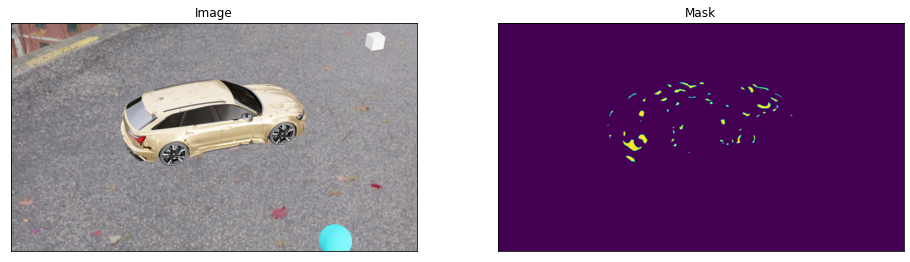

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(ids_synthetic)
dataset = dataset.map(parse_image(images_dir=x_dir_synthetic, masks_dir=y_dir_synthetic))


image, mask = next(iter(dataset))
image = image.numpy()
mask = mask.numpy()

visualize(
    image=image,
    mask=mask
)

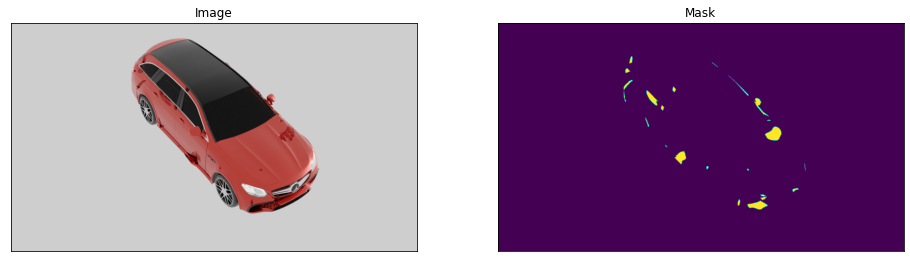

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(ids_synthetic_old)
dataset = dataset.map(parse_image(images_dir=x_dir_synthetic_old, masks_dir=y_dir_synthetic_old))


image, mask = next(iter(dataset))
image = image.numpy()
mask = mask.numpy()

visualize(
    image=image,
    mask=mask
)

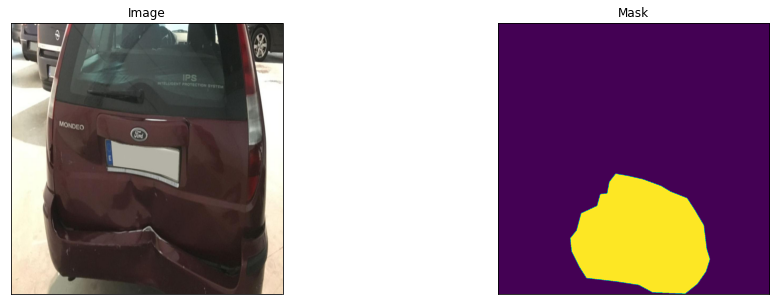

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(ids_real)
dataset = dataset.map(parse_image(images_dir=x_dir_real, masks_dir=y_dir_real))


image, mask = next(iter(dataset))
image = image.numpy()
mask = mask.numpy()

visualize(
    image=image,
    mask=mask
)

## Augmentations

Augmentations used:
- horizontal flip
- afffine transforms
- perspective transforms
- brightness/contrast/colors manipulations
- image bluring and sharpening
- guassian noise
- random crops

In [ ]:
import albumentations as A

In [ ]:
SHAPE = (576, 576)

def round_clip_0_1(x, **kwargs):
  return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
  train_transform = [
    A.HorizontalFlip(p=0.5),
    #A.PadIfNeeded(min_height=None, min_width=None, pad_height_divisor=32, pad_width_divisor=32),
    A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),
    A.Resize(SHAPE[1], SHAPE[0], interpolation=2, always_apply=True),

    # A.OneOf(
    #     [
    #       A.RandomCrop(height=CROP_SHAPE[1], width=CROP_SHAPE[0], p=1),
    #       A.CropNonEmptyMaskIfExists(height=CROP_SHAPE[1], width=CROP_SHAPE[0], p=1)
    #     ],
    #     p=1
    # ),


    # A.GaussNoise(p=0.2),
    # A.Perspective(p=0.5),
    # A.RandomBrightnessContrast(p=0.9),

    # A.OneOf(
    #     [
    #     #  A.CLAHE(p=1),
    #      A.RandomGamma(p=1),
    #     ],
    #     p=0.9,
    # ),

    # A.OneOf(
    #     [
    #      A.Sharpen(p=1),
    #      A.Blur(blur_limit=3, p=1),
    #      A.MotionBlur(blur_limit=3, p=1),
    #     ],
    #     p=0.9,
    # ),

    # A.OneOf(
    #     [
    #      A.HueSaturationValue(p=1)
    #     ],
    #     p=0.9,
    # ),
    A.Lambda(mask=round_clip_0_1)
  ]

  return A.Compose(train_transform)

def get_validation_augmentation():
  """Add paddings to make image shape divisible by 32"""
  test_transform = [
  #   A.PadIfNeeded(min_height=None, min_width=None, pad_height_divisor=48, pad_width_divisor=48)
  A.Resize(SHAPE[1], SHAPE[0], interpolation=2, always_apply=True),
  ]
  return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
  """Construct preprocessing transform

  Args:
    preprocessing_fn (callback): data normalization function
      (can be specific for each pretrained neural network)
  Return:
    transform: albumentations.Compose
  
  """

  _transform = [
    A.Lambda(image=preprocessing_fn),
  ]
  return A.Compose(_transform)

In [ ]:
def aug(transforms):
  @tf.function
  def augment(image: tf.Tensor, mask: tf.Tensor) -> tuple:
    def aug_fn(image, mask):
      datapoint = {"image": image, "mask": mask}
      aug_data = transforms(**datapoint)
      aug_image = aug_data["image"]
      aug_mask = aug_data["mask"]
      return aug_image, aug_mask

    aug_image, aug_mask = tf.numpy_function(func=aug_fn, inp=[image, mask], Tout=(tf.float32, tf.float32))
    return aug_image, aug_mask
  
  return augment

### Augmented Dataset Examples

In [ ]:
BATCH_SIZE = 32

# for reference about the BUFFER_SIZE in shuffle:
# https://stackoverflow.com/questions/46444018/meaning-of-buffer-size-in-dataset-map-dataset-prefetch-and-dataset-shuffle
BUFFER_SIZE = 100

# dataset = tf.data.Dataset.from_tensor_slices(ids_synthetic)
# dataset = dataset.map(parse_image(images_dir=x_dir_synthetic, masks_dir=y_dir_synthetic))
# dataset = dataset.map(aug(get_training_augmentation()), num_parallel_calls=tf.data.experimental.AUTOTUNE)
# dataset = dataset.shuffle(buffer_size=BUFFER_SIZE, seed=SEED)
# dataset = dataset.repeat()
# dataset = dataset.batch(BATCH_SIZE)
# dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


# image, mask = next(iter(dataset))
# images = image.numpy()
# masks = mask.numpy()

# for i in range(32):
#   visualize(
#       image=image[i],
#       mask=mask[i]
#   )

# del dataset
# gc.collect()

# Model Loading and Configuration

In [ ]:
import segmentation_models as sm
import datetime, os
from IPython.display import clear_output

Segmentation Models: using `tf.keras` framework.


## Model Evaluation Utils

In [ ]:
def print_scores(scores, model_name):
  print(f'{model_name} Scores:')
  print("\t- Loss: {:.5}".format(scores[0]))
  for metric, value in zip(metrics, scores[1:]):
      print("\t- Mean {}: {:.5}".format(metric.__name__, value))
  print('')

In [ ]:
# see https://www.youtube.com/watch?v=LM9yisNYfyw
# and https://github.com/bnsreenu/python_for_microscopists/blob/master/206_sem_segm_large_images_using_unet_with_custom_patch_inference.py

def patch_prediction(model, image, patch_size, step_size):
    width, height = image.shape[:2]
    segm_img = np.zeros((width, height, 1))
    patch_num = 1
    for i in range(0, image.shape[0], step_size):
        for j in range(0, image.shape[1], step_size):
            single_patch = image[i:i+patch_size, j:j+patch_size]
            single_patch = single_patch[tf.newaxis, ...]
            if single_patch.shape[1:3] == (patch_size, patch_size):
                pred_mask_patch = model.predict(single_patch)
                #pred_mask_patch = pred_mask_patch.round()
                segm_img[i:i+patch_size, j:j+patch_size] = pred_mask_patch
                #print(f"Finished processing patch number {patch_num} at position ({i}, {j})")
                patch_num += 1
            
    return segm_img[tf.newaxis, ...]

In [ ]:
def plot_example_predictions(model, dataset, n):
  ids = np.random.choice(np.arange(len(dataset)), size=n)

  for i in ids:
      
    image, gt_mask = dataset[i]
    #image = np.expand_dims(image, axis=0)
    #pr_mask = model.predict(image).round()
    pr_mask = patch_prediction(model, image, patch_size=128, step_size=64)
    pr_mask_heat = pr_mask * 255
    pr_mask = pr_mask.round()

    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask[..., 0].squeeze(),
        pr_mask=pr_mask[..., 0].squeeze(),
        pr_mask_heat=pr_mask_heat[..., 0].squeeze()
    )

## Configure Models

In [ ]:
# encoder parameteres
BACKBONE = 'efficientnetb7'
ENCODER_WEIGHTS = 'imagenet'
#ENCODER_FREEZE = False

# decoder parameters
N_CLASSES = 1
ACTIVATION = 'sigmoid'

# load preprocessor for specified encoder network
preprocess_input = sm.get_preprocessing(BACKBONE)

## Load Final Datasets

In [ ]:
def get_train_dataset_synthetic():
  BATCH_SIZE = 2
  BUFFER_SIZE = 100

  ids = train_ids_synthetic
  x_dir = x_dir_synthetic
  y_dir = y_dir_synthetic

  steps_per_epoch = int(np.ceil(len(ids) / BATCH_SIZE))

  dataset = tf.data.Dataset.from_tensor_slices(ids)
  dataset = dataset.map(parse_image(images_dir=x_dir, masks_dir=y_dir))
  dataset = dataset.map(aug(get_training_augmentation()), num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.map(aug(get_preprocessing(preprocess_input)), num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.shuffle(buffer_size=BUFFER_SIZE, seed=SEED)
  dataset = dataset.repeat()
  dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

  return dataset, steps_per_epoch

def get_valid_dataset_synthetic():
  BATCH_SIZE = 1

  ids = valid_ids_synthetic
  x_dir = x_dir_synthetic
  y_dir = y_dir_synthetic

  steps_per_epoch = int(np.ceil(len(ids) / BATCH_SIZE))

  dataset = tf.data.Dataset.from_tensor_slices(ids)
  dataset = dataset.map(parse_image(images_dir=x_dir, masks_dir=y_dir))
  dataset = dataset.map(aug(get_validation_augmentation()), num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.map(aug(get_preprocessing(preprocess_input)), num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

  return dataset, steps_per_epoch

def get_train_dataset_synthetic_old():
  BATCH_SIZE = 8
  BUFFER_SIZE = 100

  ids = train_ids_synthetic_old
  x_dir = x_dir_synthetic_old
  y_dir = y_dir_synthetic_old

  steps_per_epoch = int(np.ceil(len(ids) / BATCH_SIZE))

  dataset = tf.data.Dataset.from_tensor_slices(ids)
  dataset = dataset.map(parse_image(images_dir=x_dir, masks_dir=y_dir))
  dataset = dataset.map(aug(get_training_augmentation()), num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.map(aug(get_preprocessing(preprocess_input)), num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.shuffle(buffer_size=BUFFER_SIZE, seed=SEED)
  dataset = dataset.repeat()
  dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

  return dataset, steps_per_epoch

def get_valid_dataset_synthetic_old():
  BATCH_SIZE = 1

  ids = valid_ids_synthetic_old
  x_dir = x_dir_synthetic_old
  y_dir = y_dir_synthetic_old

  steps_per_epoch = int(np.ceil(len(ids) / 1))

  dataset = tf.data.Dataset.from_tensor_slices(ids)
  dataset = dataset.map(parse_image(images_dir=x_dir, masks_dir=y_dir))
  dataset = dataset.map(aug(get_validation_augmentation()), num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.map(aug(get_preprocessing(preprocess_input)), num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

  return dataset, steps_per_epoch

def get_train_dataset_real():
  BATCH_SIZE = 1
  BUFFER_SIZE = 100

  ids = train_ids_real
  x_dir = x_dir_real
  y_dir = y_dir_real

  steps_per_epoch = int(np.ceil(len(ids) / BATCH_SIZE))

  dataset = tf.data.Dataset.from_tensor_slices(ids)
  dataset = dataset.map(parse_image(images_dir=x_dir, masks_dir=y_dir))
  dataset = dataset.map(aug(get_training_augmentation()), num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.map(aug(get_preprocessing(preprocess_input)), num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.shuffle(buffer_size=BUFFER_SIZE, seed=SEED)
  dataset = dataset.repeat()
  dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

  return dataset, steps_per_epoch

def get_valid_dataset_real():
  BATCH_SIZE = 1

  ids = valid_ids_real
  x_dir = x_dir_real
  y_dir = y_dir_real

  steps_per_epoch = int(np.ceil(len(ids) / 1))

  dataset = tf.data.Dataset.from_tensor_slices(ids)
  dataset = dataset.map(parse_image(images_dir=x_dir, masks_dir=y_dir))
  dataset = dataset.map(aug(get_validation_augmentation()), num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.map(aug(get_preprocessing(preprocess_input)), num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

  return dataset, steps_per_epoch

def get_test_dataset_real():
  BATCH_SIZE = 1

  ids = test_ids_real
  x_dir = x_dir_real
  y_dir = y_dir_real

  steps_per_epoch = int(np.ceil(len(ids) / 1))

  dataset = tf.data.Dataset.from_tensor_slices(ids)
  dataset = dataset.map(parse_image(images_dir=x_dir, masks_dir=y_dir))
  dataset = dataset.map(aug(get_validation_augmentation()), num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.map(aug(get_preprocessing(preprocess_input)), num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

  return dataset, steps_per_epoch

## Load Models

In [ ]:
def freeze_encoder(model):
  for layer in model.layers[:155]:
    layer.trainable = False

def unfreeze_encoder(model):
  for layer in model.layers[:155]:
    layer.trainable = True

In [ ]:
def build_synthetic_model(hp):
  model_arch = "pspnet"

  if model_arch == "unet":
    model = sm.Unet(
        BACKBONE, 
        encoder_weights=ENCODER_WEIGHTS, 
        classes=N_CLASSES, 
        activation=ACTIVATION, 
        #encoder_freeze=hp.Boolean("sm_encoder_freeze"),
        #decoder_use_batchnorm=hp.Boolean("use_batchnorm"),
    )
  elif model_arch == "linknet":
    model = sm.Linknet(
        BACKBONE, 
        encoder_weights=ENCODER_WEIGHTS, 
        classes=N_CLASSES, 
        activation=ACTIVATION, 
        #encoder_freeze=hp.Boolean("sm_encoder_freeze"),
        #decoder_use_batchnorm=hp.Boolean("use_batchnorm"),
    )
  elif model_arch == "fpn":
    model = sm.FPN(
        BACKBONE, 
        encoder_weights=ENCODER_WEIGHTS, 
        classes=N_CLASSES, 
        activation=ACTIVATION, 
        #encoder_freeze=hp.Boolean("sm_encoder_freeze"),
        #pyramid_use_batchnorm=hp.Boolean("use_batchnorm"),
    )
  elif model_arch == "pspnet":
    model = sm.PSPNet(
        BACKBONE, 
        input_shape=(SHAPE[1], SHAPE[0], 3),
        encoder_weights=ENCODER_WEIGHTS, 
        classes=N_CLASSES, 
        activation=ACTIVATION,
        downsample_factor = hp.Choice("downsample_factor", [4, 8, 16]),
        #encoder_freeze=hp.Boolean("sm_encoder_freeze"),
        #psp_use_batchnorm=hp.Boolean("use_batchnorm"),
    )
  
  #if hp.Boolean("custom_encoder_freeze"):
  freeze_encoder(model)

  lr = hp.Float("lr", min_value=1e-5, max_value=1e-2, sampling="log")
  optim = tf.keras.optimizers.Adam(lr)
  loss = sm.losses.JaccardLoss()
  metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

  model.compile(optim, loss, metrics)

  return model

## Custom Callbacks

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # clear_output(wait=True)
        plot_example_predictions(self.model, dataset_valid_synthetic, 1)
        plot_example_predictions(self.model, dataset_valid_real, 1)
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [ ]:
class RemoveGarbaseCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    gc.collect()

## Model Compilation

In [ ]:
# training parameters
EPOCHS = 50

In [ ]:
date_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

CHECKPOINT_DIR = '/content/drive/MyDrive/Machine Learning/Models'
CHECKPOINT_SYNTHETIC = f'{date_time}_synthetic_best_model.h5'
CHECKPOINT_REAL = f'{date_time}_real_best_model.h5'
CHECKPOINT_MIXED = f'{date_time}_mixed_heavy_aug_real_encoder_frozen_best_model.h5'

checkpoint_path_synthetic = os.path.join(CHECKPOINT_DIR, CHECKPOINT_SYNTHETIC)
checkpoint_path_real = os.path.join(CHECKPOINT_DIR, CHECKPOINT_REAL)
checkpoint_path_mixed = os.path.join(CHECKPOINT_DIR, CHECKPOINT_MIXED)

In [ ]:
# define callbacks for learning rate scheduling and best checkpoints saving
callbacks_synthetic = [
  #DisplayCallback(),
  RemoveGarbaseCallback(),
  # tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10),
  #tf.keras.callbacks.ModelCheckpoint(checkpoint_path_synthetic, save_weights_only=True, save_best_only=True, mode='min'),
  #tf.keras.callbacks.CSVLogger(filename=checkpoint_path_synthetic.replace('.h5', '.csv'), separator=',', append=True),
  #tf.keras.callbacks.ReduceLROnPlateau(),
]

callbacks_real = [
  DisplayCallback(),
  RemoveGarbaseCallback(),
  tf.keras.callbacks.ModelCheckpoint(checkpoint_path_real, save_weights_only=True, save_best_only=True, mode='min'),
  tf.keras.callbacks.CSVLogger(filename=checkpoint_path_real.replace('.h5', '.csv'), separator=',', append=True),
  tf.keras.callbacks.ReduceLROnPlateau(),
]

callbacks_mixed = [
  DisplayCallback(),
  RemoveGarbaseCallback(),
  tf.keras.callbacks.ModelCheckpoint(checkpoint_path_mixed, save_weights_only=True, save_best_only=True, mode='min'),
  tf.keras.callbacks.CSVLogger(filename=checkpoint_path_mixed.replace('.h5', '.csv'), separator=',', append=True),
  tf.keras.callbacks.ReduceLROnPlateau(),
]

# Model Training

## Model Training Utils

In [ ]:
def plot_model_training_history(history):
  # Plot training & validation iou_score values
  plt.figure(figsize=(30, 5))
  plt.subplot(121)
  plt.plot(history.history['iou_score'])
  plt.plot(history.history['val_iou_score'])
  plt.title('Model iou_score')
  plt.ylabel('iou_score')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')

  # Plot training & validation loss value
  plt.subplot(122)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

## Train Models

In [ ]:
# train real only model
history_real = model_real.fit(
    dataloader_train_real,
    steps_per_epoch=len(dataloader_train_real),
    epochs=EPOCHS,
    callbacks=callbacks_real,
    validation_data=dataloader_valid_real,
    validation_steps=len(dataloader_valid_real),
)

plot_model_training_history(history_real)

In [ ]:
dataset_train_synthetic, steps_per_epoch = get_train_dataset_synthetic()
dataset_valid_synthetic, validation_steps = get_valid_dataset_synthetic()

synthetic_tuner = kt.BayesianOptimization(
    build_synthetic_model,
    objective=kt.Objective('val_iou_score', direction='max'),
    max_trials=20,
    seed=SEED,
    overwrite=True,
)

synthetic_tuner.search(
    dataset_train_synthetic,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    callbacks=callbacks_synthetic,
    validation_data=dataset_valid_synthetic,
    validation_steps=validation_steps,
)

synthetic_tuner.results_summary()

Trial 1 Complete [14h 01m 32s]
val_iou_score: 0.006838866975158453

Best val_iou_score So Far: 0.006838866975158453
Total elapsed time: 14h 01m 32s

Search: Running Trial #2

Hyperparameter    |Value             |Best Value So Far 
downsample_factor |8                 |16                
lr                |6.5407e-05        |1.3051e-05        

Epoch 1/50
3200/3200 [==============================] - 1565s 489ms/step - loss: 1.0000 - iou_score: 0.0033 - f1-score: 0.0066 - val_loss: 0.9998 - val_iou_score: 0.0029 - val_f1-score: 0.0058
Epoch 2/50
3200/3200 [==============================] - 1534s 479ms/step - loss: 1.0000 - iou_score: 0.0032 - f1-score: 0.0064 - val_loss: 0.9998 - val_iou_score: 0.0025 - val_f1-score: 0.0049
Epoch 3/50
3200/3200 [==============================] - 1537s 480ms/step - loss: 1.0000 - iou_score: 0.0033 - f1-score: 0.0065 - val_loss: 0.9999 - val_iou_score: 0.0029 - val_f1-score: 0.0058
Epoch 4/50
3200/3200 [==============================] - 1570s 491ms/step -

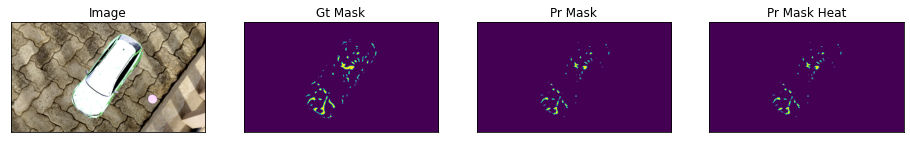

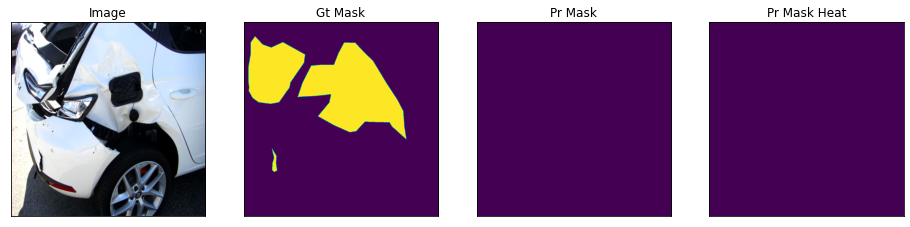


Sample Prediction after epoch 100

35/35 [==============================] - 21s 605ms/step - loss: 0.5473 - iou_score: 0.4571 - f1-score: 0.4571 - val_loss: 1.0000 - val_iou_score: 4.6164e-06 - val_f1-score: 9.2320e-06 - lr: 1.0000e-13


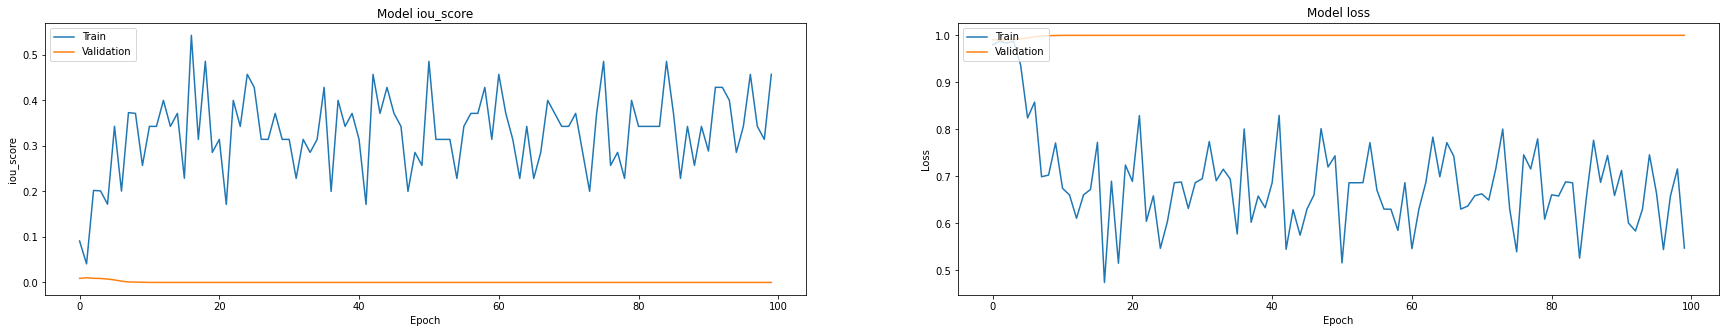

In [ ]:
# train mixed model (transfer learning)
synthetic_model_load_path = os.path.join(CHECKPOINT_DIR, '20211209-211852_synthetic_encoder_thawed_best_model.h5')
# load best synthetic weights
model_mixed.load_weights(synthetic_model_load_path)

# train best synthetic model on real data
history_mixed = model_mixed.fit(
    dataloader_train_real,
    steps_per_epoch=len(dataloader_train_real),
    epochs=100,
    callbacks=callbacks_mixed,
    validation_data=dataloader_valid_real,
    validation_steps=len(dataloader_valid_real),
)

plot_model_training_history(history_mixed)

# Model Evaludation

## Model Scores

In [ ]:
# load best weights
model_synthetic.load_weights(checkpoint_path_synthetic)
#model_real.load_weights(checkpoint_path_real)
model_mixed.load_weights(checkpoint_path_mixed)

In [ ]:
scores_synthetic = model_synthetic.evaluate(dataloader_test_real)
scores_real = model_real.evaluate(dataloader_test_real)
scores_mixed = model_mixed.evaluate(dataloader_test_real)

print_scores(scores_synthetic, 'Synthetic Model')
print_scores(scores_real, 'Real Model')
print_scores(scores_mixed, 'Mixed Model')

12/12 [==============================] - 1s 93ms/step - loss: 1.0000 - iou_score: 1.9557e-10 - f1-score: 1.9557e-10
Synthetic Model Scores:
	- Loss: 0.98908
	- Mean iou_score: 0.010923
	- Mean f1-score: 0.020531

Real Model Scores:
	- Loss: 0.92306
	- Mean iou_score: 0.066024
	- Mean f1-score: 0.12181

Mixed Model Scores:
	- Loss: 1.0
	- Mean iou_score: 1.9557e-10
	- Mean f1-score: 1.9557e-10



In [ ]:
scores_mixed = model_mixed.evaluate(dataloader_train_real)

35/35 [==============================] - 1s 30ms/step - loss: 0.8864 - iou_score: 0.7714 - f1-score: 0.7714


## Model Example Predictions

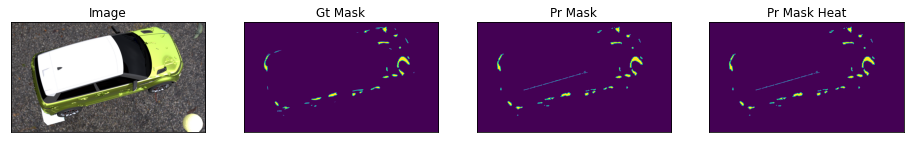

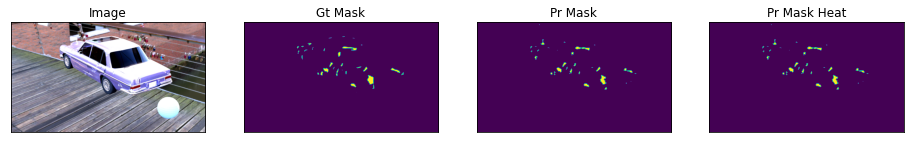

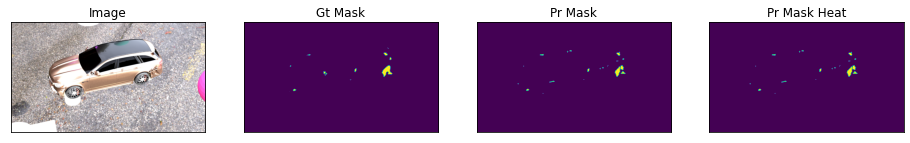

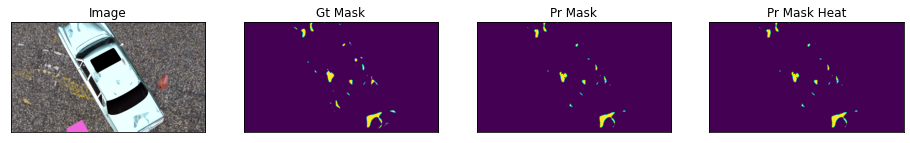

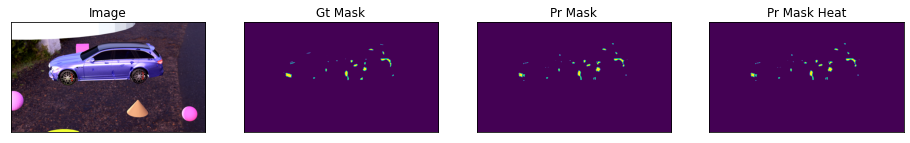

In [ ]:
# synthetic model
plot_example_predictions(model_synthetic, dataset_valid_synthetic, 5)

In [ ]:
# real model
plot_example_predictions(model_real, dataset_test_real, 5)

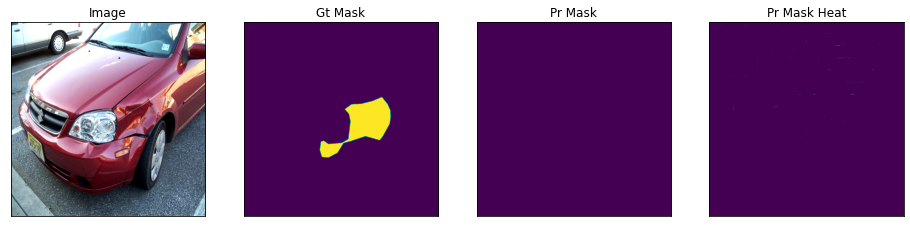

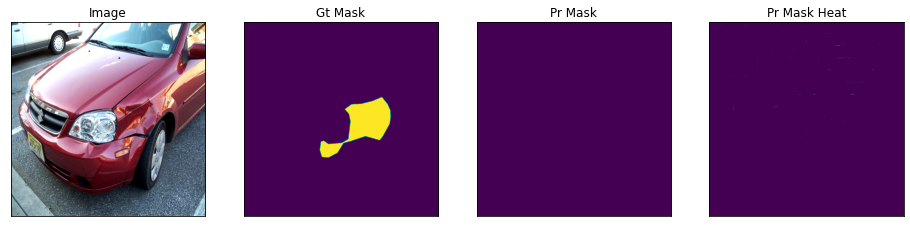

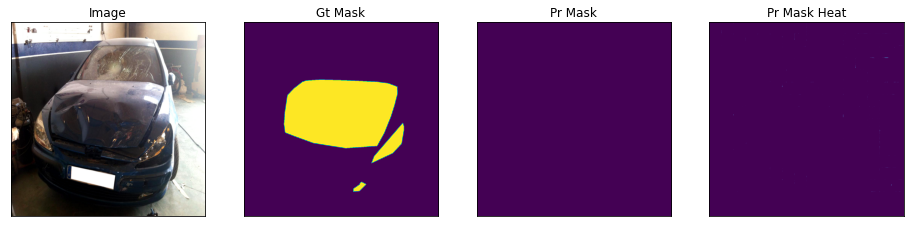

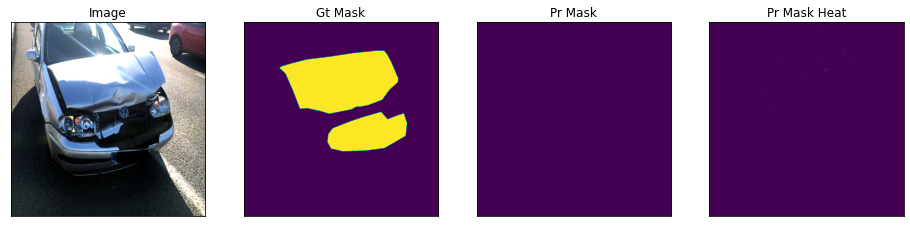

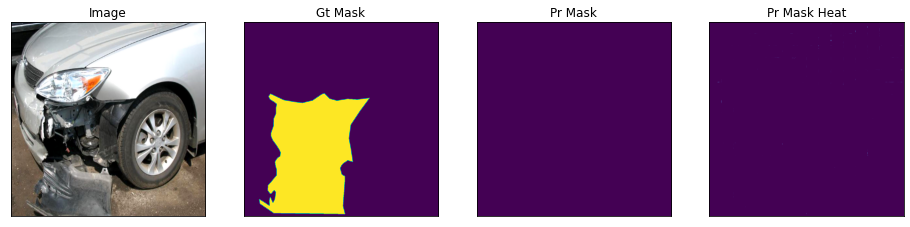

In [ ]:
# mixed model
plot_example_predictions(model_mixed, dataset_test_real, 5)